# pyDPQC #


### Python based Quality Control software utilizing PyArt
* Developed by the NASA GPM-GV group
* V0.2 - 01/14/2021 - update by Jason Pippitt NASA/GSFC/SSAI

<table><tr>
<td> <img src="./images/nasa.jpg" alt="NASA" style="width: 250px;"/> </td>
<td> <img src="./images/GPM.jpg" alt="GPM" style="width: 250px;"/> </td>
</tr></table>



## First we import functions needed to run pyDPQC.

In [1]:
import numpy as np
import pyart
import pylab
import netCDF4
import math
import sys
import glob
import os
import ast
import gc
import argparse
from copy import deepcopy
import warnings
sys.path.append('../scripts/')
import gpm_dp_utils as gu
import gpm_dpqc as qc
import plot_dpqc_images as pltqc

warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Specify which file to run.  We will use a default thresh_dict for this notebook, variables will print below.

In [2]:
file = './raw/np1200910215033.RAWMWHM.gz'
#file = './raw/KMLB20200606_120129_V06'

thresh_dict = qc.get_default_thresh_dict()

print()
print('QC parameters:    ')
print()
print(thresh_dict)


QC parameters:    

{'do_dbz': True, 'dbz_thresh': 5.0, 'do_rh': True, 'rh_thresh': 0.72, 'do_zdr': True, 'dr_min': -6.0, 'dr_max': 4.0, 'do_kdp': False, 'kdp_min': -2.0, 'kdp_max': 7.0, 'do_sq': False, 'sq_thresh': 0.45, 'do_sd': True, 'sd_thresh': 25.0, 'do_ph': False, 'ph_thresh': 80.0, 'do_ap': False, 'ap_dbz': 45, 'ap_zdr': 3, 'do_insect': False, 'do_despeckle': True, 'do_cos': False, 'coshmin': 0, 'coshmax': None, 'cosrmin': 0, 'cosrmax': 5, 'cosazmin': 0, 'cosazmax': 360, 'coselmin': 0, 'coselmax': 20.0, 'do_sector': False, 'sechmin': 0, 'sechmax': None, 'secrmin': 0, 'secrmax': 150, 'secazmin': 160, 'secazmax': 165, 'secelmin': 0, 'secelmax': 20.0, 'do_rh_sector': False, 'rhhmin': 0, 'rhhmax': None, 'rhrmin': 0, 'rhrmax': 20, 'rhazmin': 0, 'rhazmax': 360, 'rhelmin': 0, 'rhelmax': 7.0, 'rh_sec': 0.92, 'do_sd_sector': False, 'sdhmin': 0, 'sdhmax': None, 'sdrmin': 0, 'sdrmax': 20, 'sdazmin': 0, 'sdazmax': 360, 'sdelmin': 0, 'sdelmax': 7.0, 'sd_sec': 8.0, 'do_ph_sector': False, 'p

## PyArt will now read the file into a radar structure.  If NEXRAD file rsl_in_IDL will organize split cuts and remove MRLE scans.  Fields will be renamed to match GPM 2-letter field names.  A copy of raw reflectivity will be saved.  

In [3]:
radar = pyart.io.read(file, file_field_names=True)

# If radar is 88D convert file to cfRadial to organize split cuts and remove MRLE scans
if radar.metadata['original_container'] == 'NEXRAD Level II':
    radar = qc.convert_to_cf(radar, file)
# Create a filter to remove data beyond 200km
    radar = qc.mask_88D_200(radar, thresh_dict)
                
# Rename fields with GPM, 2-letter IDs (e.g. CZ, DR, KD)
qc.rename_fields_in_radar(radar)

# Save raw reflectivity, will be applied to DZ later
zz = deepcopy(radar.fields['DZ'])


Renaming radar fields...
dict_keys(['DBT2', 'DBTV16', 'DBZV16', 'SNR16', 'DZ', 'VR', 'SW', 'DR', 'KD', 'PH', 'RH', 'SQ', 'CZ'])


## Calibration numbers are applied prior to quality control.

In [4]:
#Apply calibration numbers to Reflectivity and ZDR fields
if thresh_dict['apply_cal'] == True:
    radar = qc.calibrate(radar, thresh_dict)

## If applying sector filters, they will be created below.

In [5]:
# Create a filter to remove data close to radar location (e.g. cone of silence)
if thresh_dict['do_cos'] == True:
    radar = qc.mask_cone_of_silence(radar, thresh_dict)

# Create mask to filter a range/azm/height sector of radar
if thresh_dict['do_sector'] == True:
    radar = qc.sector_wipeout(radar, thresh_dict)
           
# Create mask to filter a range/azm/height sector of radar based on RHOHV threshold
if thresh_dict['do_rh_sector'] == True:
    radar = qc.rh_sector(radar, thresh_dict)

## Now we create a temperature and height field.  This will allow DPQC to apply thresholds based on height of the freezing level or beam height.

In [6]:
# Create Temperature and/or Height field
if thresh_dict['use_sounding'] == True:
    if thresh_dict['sounding_type'] == 'ruc':
        radar = qc.use_ruc_sounding(radar, thresh_dict)
    if thresh_dict['sounding_type'] == 'uwy':
        radar = qc.use_uwy_sounding(radar, thresh_dict)
    if thresh_dict['sounding_type'] == 'ruc_archive':
        radar = qc.get_ruc_sounding(radar, thresh_dict)
if thresh_dict['use_sounding'] == False:
    radar = gu.get_beam_height(radar)


Calculating beam height...



## The following functions will apply CSU_RadarTools filters, threshold gatefilters, unfold PhiDP, calculate KDP and Std(PhiDP).

In [7]:
# Apply CSU_RT filters
radar = qc.csu_filters(radar, thresh_dict)
                                                  
#Apply gatefilters on DP fields
qc.threshold_qc_dpfields(radar, thresh_dict)

# Unfold PhiDP
qc.unfold_phidp(radar)
        
# Get KDP and Std(PhiDP)
qc.calculate_kdp(radar)
        
# Create mask to filter a range/azm/height sector of radar based on SD threshold
if thresh_dict['do_sd_sector'] == True:
    radar = qc.sd_sector(radar, thresh_dict)
                  
# Create mask to filter a range/azm/height sector of radar based on PH threshold
if thresh_dict['do_ph_sector'] == True:
    radar = qc.ph_sector(radar, thresh_dict)
                
# Perform gatefilters for calculated fields
qc.threshold_qc_calfields(radar, thresh_dict)

Begin Quality Control:  
    Thresholding DP Fields...
    Unfolding PhiDP...
    Getting new Kdp...
    Thresholding Cal Fields...
QC Complete



## Unwanted fields are removed, and a quality controlled cfRadial will be output.

In [8]:
# Remove unwanted fields from radar
radar.add_field('DZ', zz, replace_existing=True)

qc.remove_fields_from_radar(radar)
        
# Write cfRadial file
qc.output_cf(radar, thresh_dict)

Removing unwanted fields...

FINAL FIELDS -->  
dict_keys(['DZ', 'VR', 'SW', 'DR', 'KD', 'PH', 'RH', 'SQ', 'CZ', 'SD'])

Output cfRadial --> ./cf/NPOL1_2020_0910_215040_PPI.cf



## Plot images of QC'd fields.

Plotting PPI images...
  --> ./plots/NPOL1_2020_0910_215040_8panel_sw00_PPI.png



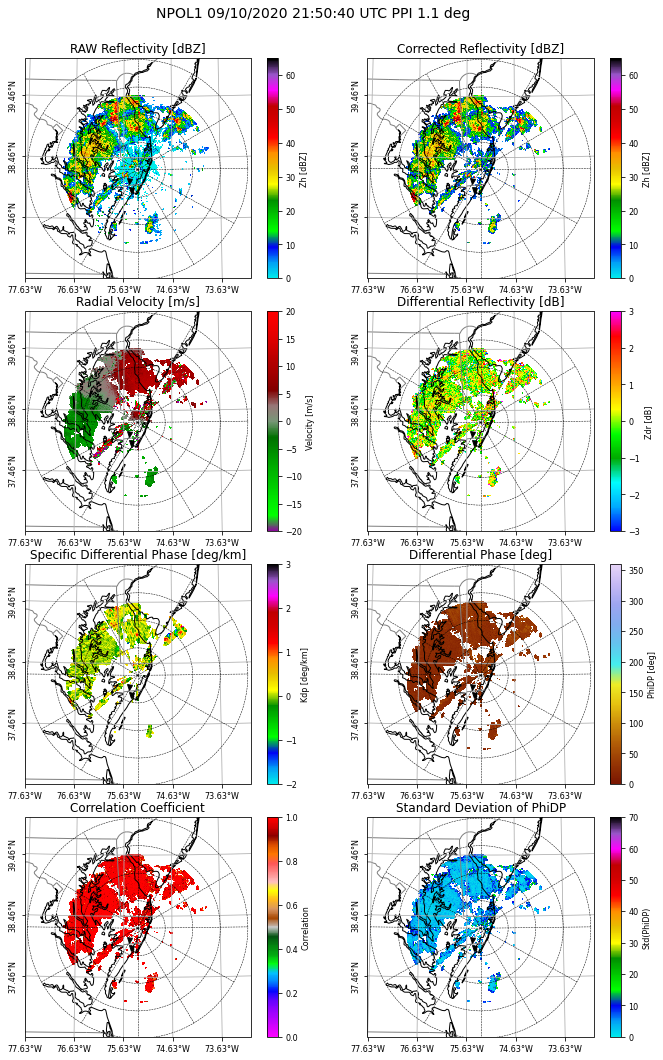

In [9]:
# Plotting images 
if thresh_dict['plot_images'] == True:   
    pltqc.plot_fields(radar, thresh_dict)